In [1]:
import keras
import shutil
import os

In [2]:
!wget https://www.dropbox.com/scl/fi/zmaqgi3vcjf1batyzoqia/archive_3.zip?rlkey=dyws5s9ix985dc6erenryno7t&dl=0
!ls

--2023-11-15 17:30:36--  https://www.dropbox.com/scl/fi/zmaqgi3vcjf1batyzoqia/archive_3.zip?rlkey=dyws5s9ix985dc6erenryno7t
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc88679911ed7f94d4cfeeac0be.dl.dropboxusercontent.com/cd/0/inline/CHmXnpsp8a86LtXf0yWCPhX7p4v-LUKMgdlLUzR0fHDL-5s8glfPv8bqaBM3LMHxLhslDCdcpyJ00OZAAxBrMwk7BHBoDXATHsjJWVyJOgsuAR21B8b5Lfw9hVxhu7C09_YRf2winY05Gp38qaiXhwzU/file# [following]
--2023-11-15 17:30:37--  https://ucc88679911ed7f94d4cfeeac0be.dl.dropboxusercontent.com/cd/0/inline/CHmXnpsp8a86LtXf0yWCPhX7p4v-LUKMgdlLUzR0fHDL-5s8glfPv8bqaBM3LMHxLhslDCdcpyJ00OZAAxBrMwk7BHBoDXATHsjJWVyJOgsuAR21B8b5Lfw9hVxhu7C09_YRf2winY05Gp38qaiXhwzU/file
Resolving ucc88679911ed7f94d4cfeeac0be.dl.dropboxusercontent.com (ucc88679911ed7f94d4cfeeac0be.dl.dropboxusercontent.com)... 162.125.64.15, 2

In [3]:
!unzip -q archive_3.zip?rlkey=dyws5s9ix985dc6erenryno7t

In [4]:

os.mkdir("/content/Images")

original = r'/content/Positive'
target = r'/content/Images/Positive'

shutil.move(original,target)

original = r'/content/Negative'
target = r'/content/Images/Negative'

shutil.move(original,target)

'/content/Images/Negative'

In [6]:
!pip install split-folders

In [7]:
import splitfolders

splitfolders.ratio("Images", output="Data1", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

base_dir = '/content/Data1'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

train_pos_dir = os.path.join(train_dir, 'Positive')
train_neg_dir = os.path.join(train_dir, 'Negative')
val_pos_dir = os.path.join(validation_dir, 'Positive')
val_neg_dir = os.path.join(validation_dir, 'Negative')

Copying files: 40000 files [00:05, 7099.65 files/s]


In [8]:
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(120, 120),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(120, 120),
        batch_size=20,
        class_mode='categorical')


Found 32000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


#EfficientNet

In [10]:
from tensorflow.keras.applications import EfficientNetB5
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential

base_model = EfficientNetB5(include_top=False, weights="imagenet", input_shape=(120, 120, 3))


115263384/115263384 [==============================] - 5s 0us/step


In [11]:

base_model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 120, 120, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 120, 120, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 120, 120, 3)          0         ['normalization[0

In [12]:

base_model.trainable = False
efficient_net = keras.models.Sequential()
efficient_net.add(base_model)
efficient_net.add(Flatten())
efficient_net.add(Dense(512, activation='relu'))
efficient_net.add(Dense(2, activation='sigmoid'))
efficient_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 4, 4, 2048)        28513527  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 45292281 (172.78 MB)
Trainable params: 16778754 (64.01 MB)
Non-trainable params: 28513527 (108.77 MB)
_________________________________________________________________


In [13]:

efficient_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [14]:
history = efficient_net.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Epoch 1/5
100/100 [==============================] - 43s 156ms/step - loss: 3.6207 - tp: 760.0000 - fp: 736.0000 - tn: 1264.0000 - fn: 1240.0000 - accuracy: 0.5060 - precision: 0.5080 - recall: 0.3800 - auc: 0.5220 - val_loss: 0.4732 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1000.0000 - val_fn: 1000.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8590
Epoch 2/5
100/100 [==============================] - 12s 116ms/step - loss: 0.5217 - tp: 571.0000 - fp: 332.0000 - tn: 1668.0000 - fn: 1429.0000 - accuracy: 0.5598 - precision: 0.6323 - recall: 0.2855 - auc: 0.6535 - val_loss: 0.4137 - val_tp: 1000.0000 - val_fp: 1000.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.8927
Epoch 3/5
100/100 [==============================] - 11s 112ms/step - loss: 0.4875 - tp: 1998.0000 - fp: 1959.0000 - tn: 41.0000 - fn: 2.0000 - accuracy: 0.5098 - precision: 0.5049 - recal

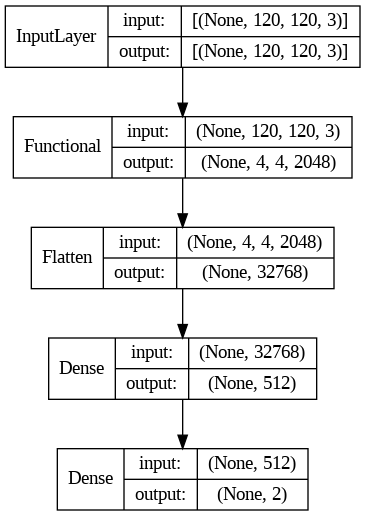

In [15]:


from tensorflow.keras.utils import plot_model
plot_model(efficient_net, to_file='efficient_net.png', show_layer_names=False, show_shapes=True)

In [16]:
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

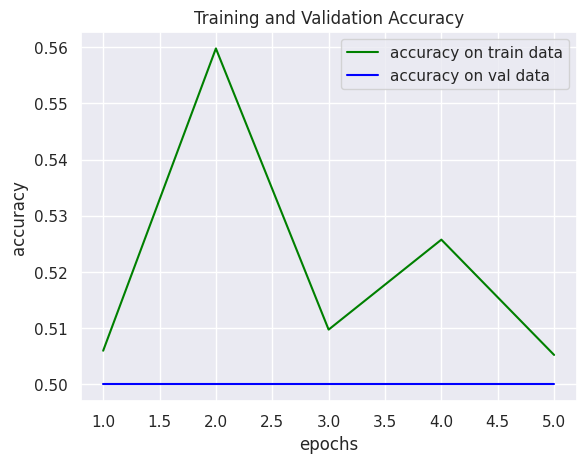

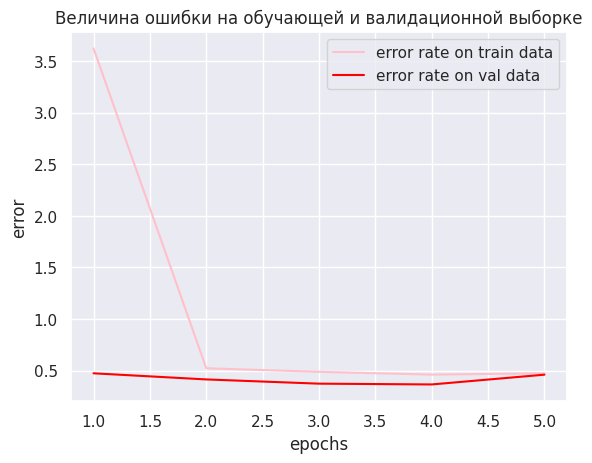

In [17]:
import matplotlib.pyplot as plt

plt.plot(epochs, acc, color='green', label='accuracy on train data')
plt.plot(epochs, val_acc, color='blue', label='accuracy on val data')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.figure()
plt.plot(epochs, loss, color='pink', label='error rate on train data')
plt.plot(epochs, val_loss, color='red', label='error rate on val data')
plt.title('error rate on train and val data')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()


In [19]:
print('accuracy EfficientNetB5 on val data = {} %'.format(val_acc[-1] * 100), '. error rate = {}'.format(val_loss[-1]))


accuracy EfficientNetB5 on val data = 50.0 % . error rate = 0.4599050283432007


ResNet-50

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [21]:
res_net = Sequential()
res_net.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

res_net.add(Dense(2, activation='softmax'))
res_net.layers[0].trainable = False

94765736/94765736 [==============================] - 4s 0us/step


In [22]:
res_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [23]:
res_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [24]:
history = res_net.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)


Epoch 1/5
100/100 [==============================] - 12s 72ms/step - loss: 0.6625 - tp: 2274.0000 - fp: 1726.0000 - tn: 1274.0000 - fn: 726.0000 - accuracy: 0.5913 - precision: 0.5685 - recall: 0.7580 - auc: 0.6206 - val_loss: 0.6216 - val_tp: 570.0000 - val_fp: 430.0000 - val_tn: 570.0000 - val_fn: 430.0000 - val_accuracy: 0.5700 - val_precision: 0.5700 - val_recall: 0.5700 - val_auc: 0.7649
Epoch 2/5
100/100 [==============================] - 5s 53ms/step - loss: 0.5919 - tp: 1681.0000 - fp: 319.0000 - tn: 1681.0000 - fn: 319.0000 - accuracy: 0.8405 - precision: 0.8405 - recall: 0.8405 - auc: 0.9227 - val_loss: 0.5478 - val_tp: 971.0000 - val_fp: 29.0000 - val_tn: 971.0000 - val_fn: 29.0000 - val_accuracy: 0.9710 - val_precision: 0.9710 - val_recall: 0.9710 - val_auc: 0.9945
Epoch 3/5
100/100 [==============================] - 6s 62ms/step - loss: 0.5241 - tp: 1852.0000 - fp: 148.0000 - tn: 1852.0000 - fn: 148.0000 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9703

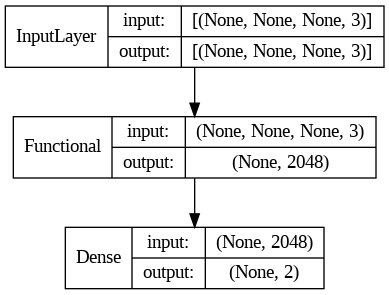

In [25]:

plot_model(res_net, to_file='res_net.png', show_layer_names=False, show_shapes=True)

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

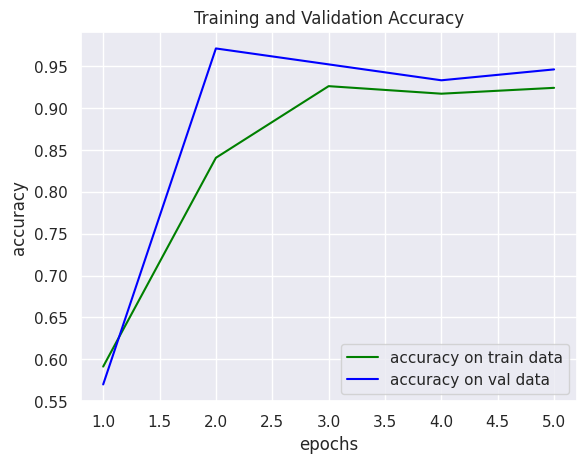

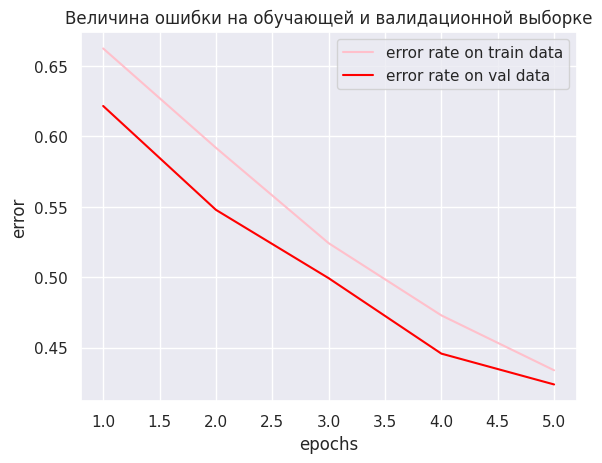

In [27]:
plt.plot(epochs, acc, color='green', label='accuracy on train data')
plt.plot(epochs, val_acc, color='blue', label='accuracy on val data')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.figure()
plt.plot(epochs, loss, color='pink', label='error rate on train data')
plt.plot(epochs, val_loss, color='red', label='error rate on val data')
plt.title('error rate on train and val data')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()

In [28]:
print('accuracy ResNet-50  on val data = {} %'.format(val_acc[-1] * 100), '. error rate = {}'.format(val_loss[-1]))


accuracy ResNet-50  on val data = 94.59999799728394 % . error rate = 0.4237534999847412


#VGG16

In [29]:
from tensorflow.keras.applications.vgg16 import VGG16


In [30]:

vgg_net = Sequential()
vgg_net.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))
vgg_net.add(Dense(2, activation='softmax'))
vgg_net.layers[0].trainable = False


58889256/58889256 [==============================] - 3s 0us/step


In [31]:

vgg_net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14715714 (56.14 MB)
Trainable params: 1026 (4.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [32]:

vgg_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [33]:

history = vgg_net.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Epoch 1/5
100/100 [==============================] - 10s 70ms/step - loss: 0.4297 - tp: 2771.0000 - fp: 229.0000 - tn: 2771.0000 - fn: 229.0000 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9659 - val_loss: 0.2542 - val_tp: 976.0000 - val_fp: 24.0000 - val_tn: 976.0000 - val_fn: 24.0000 - val_accuracy: 0.9760 - val_precision: 0.9760 - val_recall: 0.9760 - val_auc: 0.9965
Epoch 2/5
100/100 [==============================] - 6s 62ms/step - loss: 0.1918 - tp: 1950.0000 - fp: 50.0000 - tn: 1950.0000 - fn: 50.0000 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - val_loss: 0.1487 - val_tp: 980.0000 - val_fp: 20.0000 - val_tn: 980.0000 - val_fn: 20.0000 - val_accuracy: 0.9800 - val_precision: 0.9800 - val_recall: 0.9800 - val_auc: 0.9985
Epoch 3/5
100/100 [==============================] - 7s 67ms/step - loss: 0.1242 - tp: 1969.0000 - fp: 31.0000 - tn: 1969.0000 - fn: 31.0000 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9989 - val_

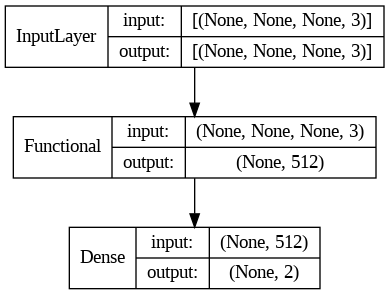

In [34]:
plot_model(vgg_net, to_file='vgg_net.png', show_layer_names=False, show_shapes=True)

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

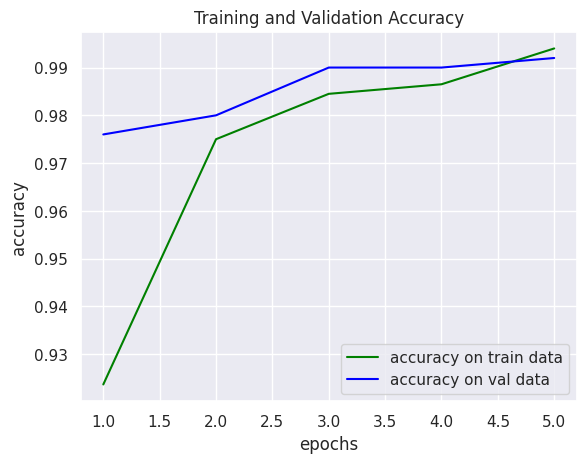

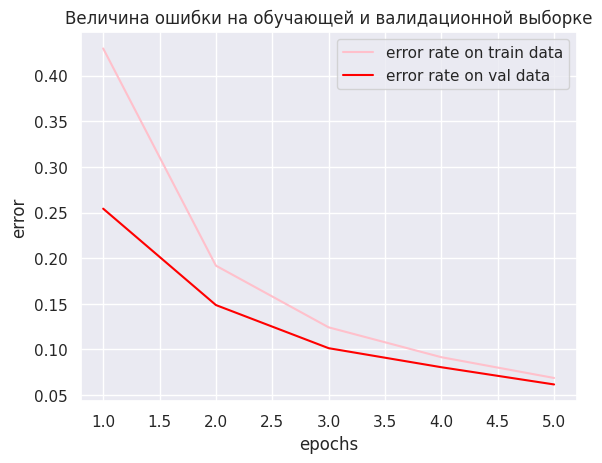

In [37]:
plt.plot(epochs, acc, color='green', label='accuracy on train data')
plt.plot(epochs, val_acc, color='blue', label='accuracy on val data')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.figure()
plt.plot(epochs, loss, color='pink', label='error rate on train data')
plt.plot(epochs, val_loss, color='red', label='error rate on val data')
plt.title('Величина ошибки на обучающей и валидационной выборке')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()

In [38]:
print('accuracy VGG16 on val data = {} %'.format(val_acc[-1] * 100), '. error rate = {}'.format(val_loss[-1]))


accuracy VGG16 on val data = 99.19999837875366 % . error rate = 0.06169433146715164


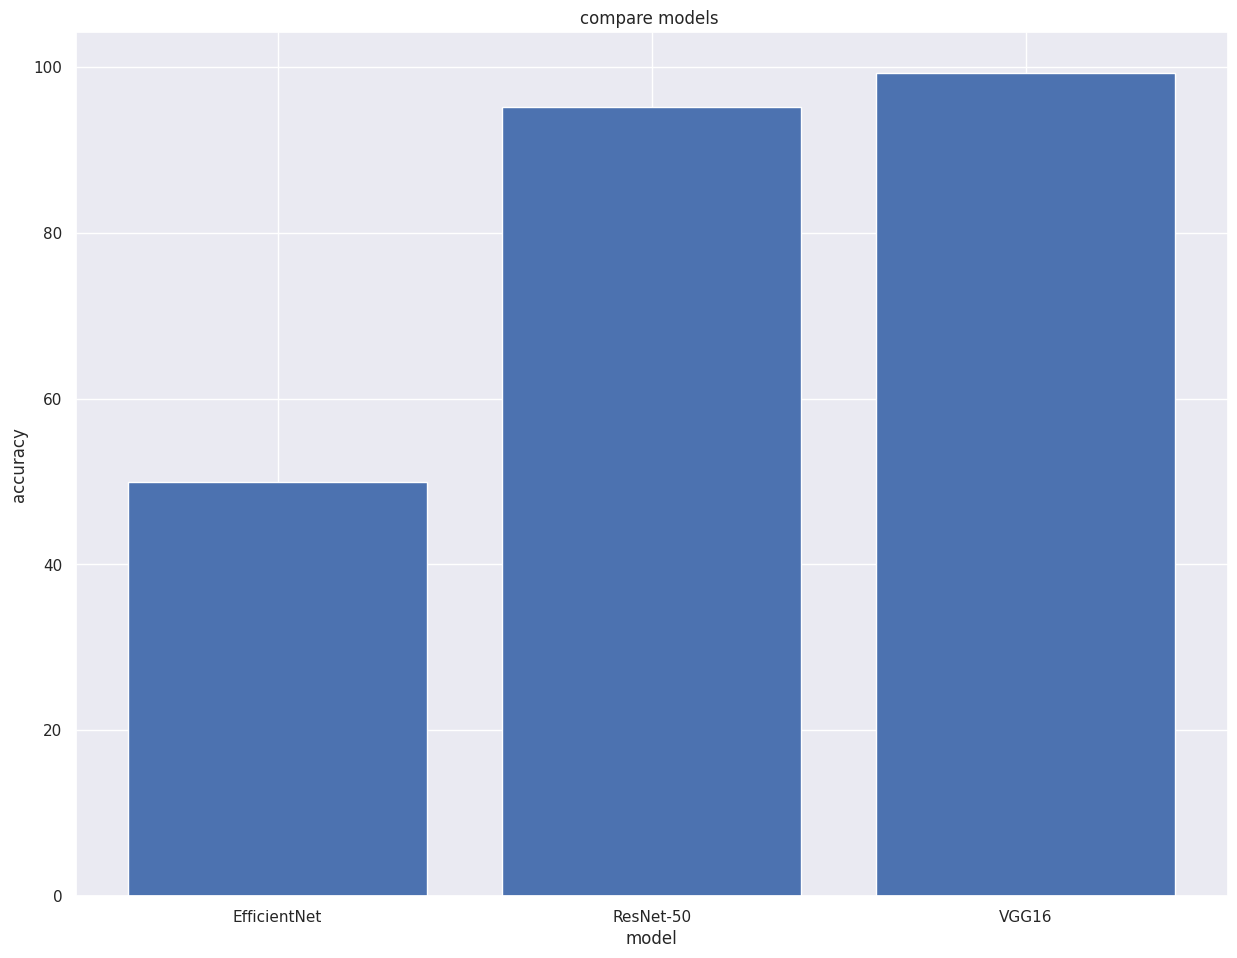

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0, 1.8, 1.8])
algo = ['EfficientNet','ResNet-50', 'VGG16']
acc = [50, 95.2, 99.2]
ax.bar(algo, acc)
ax.set_xlabel('model')
ax.set_ylabel('accuracy')
ax.set_title('compare models ')
plt.show()
